In [ ]:
!pip install langchain > /dev/null
!pip install chromadb > /dev/null
!pip install openai > /dev/null
!pip install tiktoken > /dev/null

# QA over Documents with LangChain

Here we walk through how to use LangChain for question answering over a document. Under the hood we'll be using [LangChain's Document chains](https://python.langchain.com/docs/modules/chains/document/).

We will be using [OpenAI's Embeddings](https://platform.openai.com/docs/guides/embeddings) and GPT, so let's set up our OpenAI API Key.

In [ ]:
import getpass

openai_api_key = getpass.getpass(prompt='Enter your OpenAI API Key: ')

Enter your OpenAI API Key: ··········


## Preparing the Data

Let's load our data using [LangChain](https://python.langchain.com/docs) and [ChromaDB](https://www.trychroma.com/), obtaining our text from [Chip Huyen's post about Infrastructure in Data Science](https://huyenchip.com/2021/09/13/data-science-infrastructure.html).

In [ ]:
from langchain.docstore.document import Document
from langchain.document_loaders import WebBaseLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.indexes.vectorstore import VectorstoreIndexCreator
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma

loader = WebBaseLoader("https://huyenchip.com/2021/09/13/data-science-infrastructure.html")
data = loader.load()
data = data[0].page_content

In [ ]:
data

'\n\n\n\n\n\nWhy data scientists shouldn‚Äôt need to know Kubernetes\n\n\n\n\n\n\n\n\n\n\n\n\n\nWhy data scientists shouldn‚Äôt need to know Kubernetes | Chip Huyen\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nChip Huyen\n\n\n\n\n\n\n\n\n\n\n\n\n\nBooks\nBlog\nList 100\nMLOps Guide\nTi·∫øng Vi·ªát\n\n\n\n\n\n\n\n\nWhy data scientists shouldn‚Äôt need to know Kubernetes\n\n\n        \n        Sep 13, 2021\n      \n      \n        ‚Ä¢ Chip Huyen\n\n\n\n[Hacker News discussion, Twitter thread]\nRecently, there have been many heated discussions on what the job of a data scientist should entail [1, 2, 3]. Many companies expect data scientists to be full-stack, which includes knowing lower-level infrastructure tools such as Kubernetes (K8s) and resource management.\nThis post is to argue that while it‚Äôs good for data scientists to own the entire stack, they can do so without having to know K8s if they leverage a good infrastructure abstraction tool that allows them to focus on actual data sc

Let's split our text in chunks, and obtain embeddings out of it.

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1248, chunk_overlap=0)
texts = text_splitter.split_text(data)
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

In [ ]:
# Delete Chroma collection if there is one saved
Chroma().delete_collection()
docsearch = Chroma.from_texts(texts, embeddings, metadatas=[{"source": str(i)} for i in range(len(texts))]).as_retriever()

We can start answering questions with some more lines of code!

In [ ]:
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
# Load the Language Model with temperature = 0
llm = OpenAI(temperature=0, openai_api_key=openai_api_key)


In [ ]:
chain = load_qa_chain(llm, chain_type="stuff")
query = "Why did Chip Huyen become a data scientist?"
docs = docsearch.get_relevant_documents(query)
chain.run(input_documents=docs, question=query)

' Chip Huyen became a data scientist because they wanted to spend more time with data and less time with spinning up AWS instances, writing Dockerfiles, scheduling/scaling clusters, or debugging YAML configuration files.'

## The `stuff` Chain

Information about the `stuff` chain is available in this [LINK](https://python.langchain.com/docs/modules/chains/document/stuff).

If we want to get a better understanding of what is happening under the hood, let's take a look at how does the `stuff` chain work.

In [ ]:
chain = load_qa_chain(llm, chain_type="stuff")
query = "Why did Chip Huyen become a data scientist?"
chain({"input_documents": docs, "question": query}, return_only_outputs=True)


{'output_text': ' Chip Huyen became a data scientist because they wanted to spend more time with data and less time with spinning up AWS instances, writing Dockerfiles, scheduling/scaling clusters, or debugging YAML configuration files.'}

##Output Parsing Example
Let's try to get a list object out of a query!

In [ ]:
from langchain.output_parsers import CommaSeparatedListOutputParser
output_parser = CommaSeparatedListOutputParser()
format_instructions = output_parser.get_format_instructions()
query = f"List three nice properties of Kubeflow and Metaflow.\n{format_instructions}"
chain = load_qa_chain(llm, chain_type="stuff")
output = chain({"input_documents": docs, "question": query}, return_only_outputs=True)
output_parser.parse(output['output_text'])

['Easy deployment', 'scalability', 'and portability.']

In [ ]:
query

'List three nice properties of Kubeflow and Metaflow.\nYour response should be a list of comma separated values, eg: `foo, bar, baz`'

### Custom Prompts

You can also use your own prompts with this chain. In this example, we will respond in Spanish.

In [ ]:
prompt_template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Answer in Spanish:"""
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)
query = "Why did Chip Huyen become a data scientist?"
chain = load_qa_chain(llm, chain_type="stuff", prompt=PROMPT)
chain({"input_documents": docs, "question": query}, return_only_outputs=True)

{'output_text': ' Chip Huyen se convirtió en un científico de datos porque quería pasar más tiempo con los datos, no con la configuración de instancias de AWS, la escritura de archivos Docker, la programación / escalado de clústeres o la depuración de archivos de configuración YAML.'}

## The `map_reduce` Chain

Information about the `map_reduce` chain is available in this [LINK](https://python.langchain.com/docs/modules/chains/document/map_reduce)

This section shows results of using the map_reduce Chain to do question answering.

In [ ]:
chain = load_qa_chain(llm, chain_type="map_reduce")

In [ ]:
query = "What is container technology designed for?"
chain({"input_documents": docs, "question": query}, return_only_outputs=True)

{'output_text': ' Container technology is designed for deploying and managing applications in a clustered environment.'}

### Intermediate Steps
We can also return the intermediate steps for `map_reduce` chains, should we want to inspect them. This is done with the `return_map_steps` variable.

In [ ]:
chain = load_qa_chain(llm, chain_type="map_reduce", return_map_steps=True)
output = chain({"input_documents": docs, "question": query}, return_only_outputs=True)

In [ ]:
map_reduce_steps = len(output['intermediate_steps'])
print(f"Amount of 'map_reduce' steps: {map_reduce_steps}")
print("---------------")
for i in range(map_reduce_steps):
    print(f"Step Number {i + 1}: {output['intermediate_steps'][i]}")
    print("---------------")
print(f"Final Answer: {output['output_text']}")

Amount of 'map_reduce' steps: 4
---------------
Step Number 1:  None
---------------
Step Number 2:  In theory, you can learn both sets of skills. In practice, the more time you spend on one means the less time you spend on another. I love Erik Bernhardsson‚Äôs analogy that expecting data scientists to know about infrastructure is like expecting app developers to know about how Linux kernels work. I became a data scientist because I wanted to spend more time with data, not with spinning up AWS instances, writing Dockerfiles, scheduling/scaling clusters, or debugging YAML configuration files.

No relevant text.
---------------
Step Number 3:  Kubernetes was essential to the DS/ML workflow.
---------------
Step Number 4:  Kubernetes + Airflow
---------------
Final Answer:  Container technology is designed for deploying and managing applications in a clustered environment.


### Custom Prompts

You can also use your own prompts with this chain. In this example, we will respond in Italian.

In [ ]:
question_prompt_template = """Use the following portion of a long document to see if any of the text is relevant to answer the question.
Return any relevant text translated into italian.
{context}
Question: {question}
Relevant text, if any, in Italian:"""
QUESTION_PROMPT = PromptTemplate(
    template=question_prompt_template, input_variables=["context", "question"]
)

combine_prompt_template = """Given the following extracted parts of a long document and a question, create a final answer italian.
If you don't know the answer, just say that you don't know. Don't try to make up an answer.

QUESTION: {question}
=========
{summaries}
=========
Answer in Italian:"""
COMBINE_PROMPT = PromptTemplate(
    template=combine_prompt_template, input_variables=["summaries", "question"]
)
chain = load_qa_chain(llm, chain_type="map_reduce", return_map_steps=True, question_prompt=QUESTION_PROMPT, combine_prompt=COMBINE_PROMPT)
output = chain({"input_documents": docs, "question": query}, return_only_outputs=True)

In [ ]:
map_reduce_steps = len(output['intermediate_steps'])
print(f"Amount of 'map_reduce' steps: {map_reduce_steps}")
print("---------------")
for i in range(map_reduce_steps):
    print(f"Step Number {i + 1}: {output['intermediate_steps'][i]}")
    print("---------------")
print(f"Final Answer: {output['output_text']}")

Amount of 'map_reduce' steps: 4
---------------
Step Number 1: 
La tecnologia dei contenitori è progettata per?
---------------
Step Number 2: 
Mentre imparavo di più sull'infrastruttura di basso livello, mi resi conto di quanto fosse irragionevole aspettarsi che i data scientist ne sapessero qualcosa. L'infrastruttura richiede un insieme molto diverso di competenze rispetto alla scienza dei dati. In teoria, è possibile imparare entrambi i set di competenze. In pratica, più tempo si spende su uno, meno tempo si spende sull'altro. Adoro l'analogia di Erik Bernhardsson che sostiene che aspettarsi che i data scientist conoscano l'infrastruttura è come aspettarsi che gli sviluppatori di app conoscano il funzionamento dei kernel Linux. Sono diventato un data scientist perché volevo trascorrere più tempo con i dati, non con l'avvio di istanze AWS, la scr
---------------
Step Number 3: 
Quando ho scritto quel tweet, credevo che Kubernetes fosse essenziale per il flusso di lavoro DS / ML. Ques

### Batch Size

When using the `map_reduce` chain, one thing to keep in mind is the batch size you are using during the map step. If this is too high, it could cause rate limiting errors. You can control this by setting the batch size on the LLM used. Note that this only applies for LLMs with this parameter. Below is an example of doing so for OpenAI:

In [ ]:
# openai_model = OpenAI(batch_size=5, temperature=0, openai_api_key=openai_api_key)

## The `refine` Chain

Information about the `refine` chain is available in this [LINK](https://python.langchain.com/docs/modules/chains/document/refine).

This sections shows results of using the `refine` Chain to do question answering.

In [ ]:
chain = load_qa_chain(llm, chain_type="refine")

In [ ]:
query = "What is container technology designed for?"
chain({"input_documents": docs, "question": query}, return_only_outputs=True)

{'output_text': '\n\nContainer technology is designed to package and isolate applications and their dependencies into standardized units for software development, testing, deployment, and management. Containers allow applications to be quickly and reliably deployed in different computing environments, making them ideal for cloud-native applications. This makes them an invaluable tool for data scientists, who can focus on their data science tasks without needing to understand the underlying infrastructure. Kubernetes is an essential part of the data science/machine learning workflow, as it allows for the efficient deployment of applications and data science tasks in different computing environments. Additionally, tools such as Airflow can be used to automate and manage the deployment of applications and data science tasks. This makes container technology an invaluable tool for data scientists, allowing them to focus on their data science tasks without needing to understand the underlyin

###Intermediate Steps

We can also return the intermediate steps for refine chains, should we want to inspect them. This is done with the `return_refine_steps` variable.

In [ ]:
chain = load_qa_chain(llm, chain_type="refine", return_refine_steps=True)
output = chain({"input_documents": docs, "question": query}, return_only_outputs=True)

In [ ]:
refine_steps = len(output['intermediate_steps'])
print(f"Amount of 'map_reduce' steps: {refine_steps}")
print("---------------")
for i in range(refine_steps):
    print(f"Step Number {i + 1}: {output['intermediate_steps'][i]}")
    print("---------------")
print(f"Final Answer: {output['output_text']}")

Amount of 'map_reduce' steps: 4
---------------
Step Number 1: 
Container technology is designed to package and isolate applications and their dependencies into standardized units for software development, testing, and deployment. Containers allow applications to be quickly and reliably deployed in different computing environments, making them ideal for cloud-native applications.
---------------
Step Number 2: 

Container technology is designed to package and isolate applications and their dependencies into standardized units for software development, testing, and deployment. Containers allow applications to be quickly and reliably deployed in different computing environments, making them ideal for cloud-native applications. This makes them an invaluable tool for data scientists, who can focus on their data science tasks without needing to understand the complexities of low-level infrastructure. Containers provide a way to quickly and reliably deploy applications in different computing

###Custom Prompts

You can also use your own prompts with this chain. In this example, we will respond in Portuguese.

In [ ]:
refine_prompt_template = (
    "The original question is as follows: {question}\n"
    "We have provided an existing answer: {existing_answer}\n"
    "We have the opportunity to refine the existing answer"
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{context_str}\n"
    "------------\n"
    "Given the new context, refine the original answer to better "
    "answer the question. "
    "If the context isn't useful, return the original answer. Reply in Portuguese."
)
refine_prompt = PromptTemplate(
    input_variables=["question", "existing_answer", "context_str"],
    template=refine_prompt_template,
)


initial_qa_template = (
    "Context information is below. \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the question: {question}\nYour answer should be in Portuguese.\n"
)
initial_qa_prompt = PromptTemplate(
    input_variables=["context_str", "question"], template=initial_qa_template
)
chain = load_qa_chain(llm, chain_type="refine", return_refine_steps=True,
                     question_prompt=initial_qa_prompt, refine_prompt=refine_prompt)
chain({"input_documents": docs, "question": query}, return_only_outputs=True)

{'intermediate_steps': ['\nA tecnologia de contêiner foi projetada para permitir que os desenvolvedores empacotem e distribuam aplicativos de forma rápida, confiável e segura.',
  '\nA tecnologia de contêiner foi projetada para permitir que os desenvolvedores empacotem e distribuam aplicativos de forma rápida, confiável e segura, permitindo que os cientistas de dados possam se concentrar em suas tarefas sem precisar se preocupar com o Kubernetes.',
  '\n\nA tecnologia de contêiner foi projetada para permitir que os desenvolvedores empacotem e distribuam aplicativos de forma rápida, confiável e segura, permitindo que os cientistas de dados possam se concentrar em suas tarefas sem precisar se preocupar com o Kubernetes. Isso significa que os cientistas de dados não precisam se preocupar com a infraestrutura de baixo nível, pois a tecnologia de contêiner foi projetada para simplificar o processo de configuração e gerenciamento de infraestrutura. Assim, eles podem se concentrar em suas tar

## Document QA with sources

We can also perform document QA and return the sources that were used to answer the question. To do this we'll just need to make sure each document has a "source" key in the metadata, and we'll use the `load_qa_with_sources` helper to construct our chain:

In [ ]:
docsearch = Chroma.from_texts(texts, embeddings, metadatas=[{"source": str(i)} for i in range(len(texts))])
query = "What tools do full-stack data scientists need?"
docs = docsearch.similarity_search(query)

In [ ]:
from langchain.chains.qa_with_sources import load_qa_with_sources_chain

chain = load_qa_with_sources_chain(llm, chain_type="stuff")
chain({"input_documents": docs, "question": query}, return_only_outputs=True)

{'output_text': ' Full-stack data scientists need tools that abstract them from the complexities of containerization, distributed processing, automatic failover, and other advanced computer science concepts.\nSOURCES: 15'}

We can choose the level of abstraction, depending on the use case.
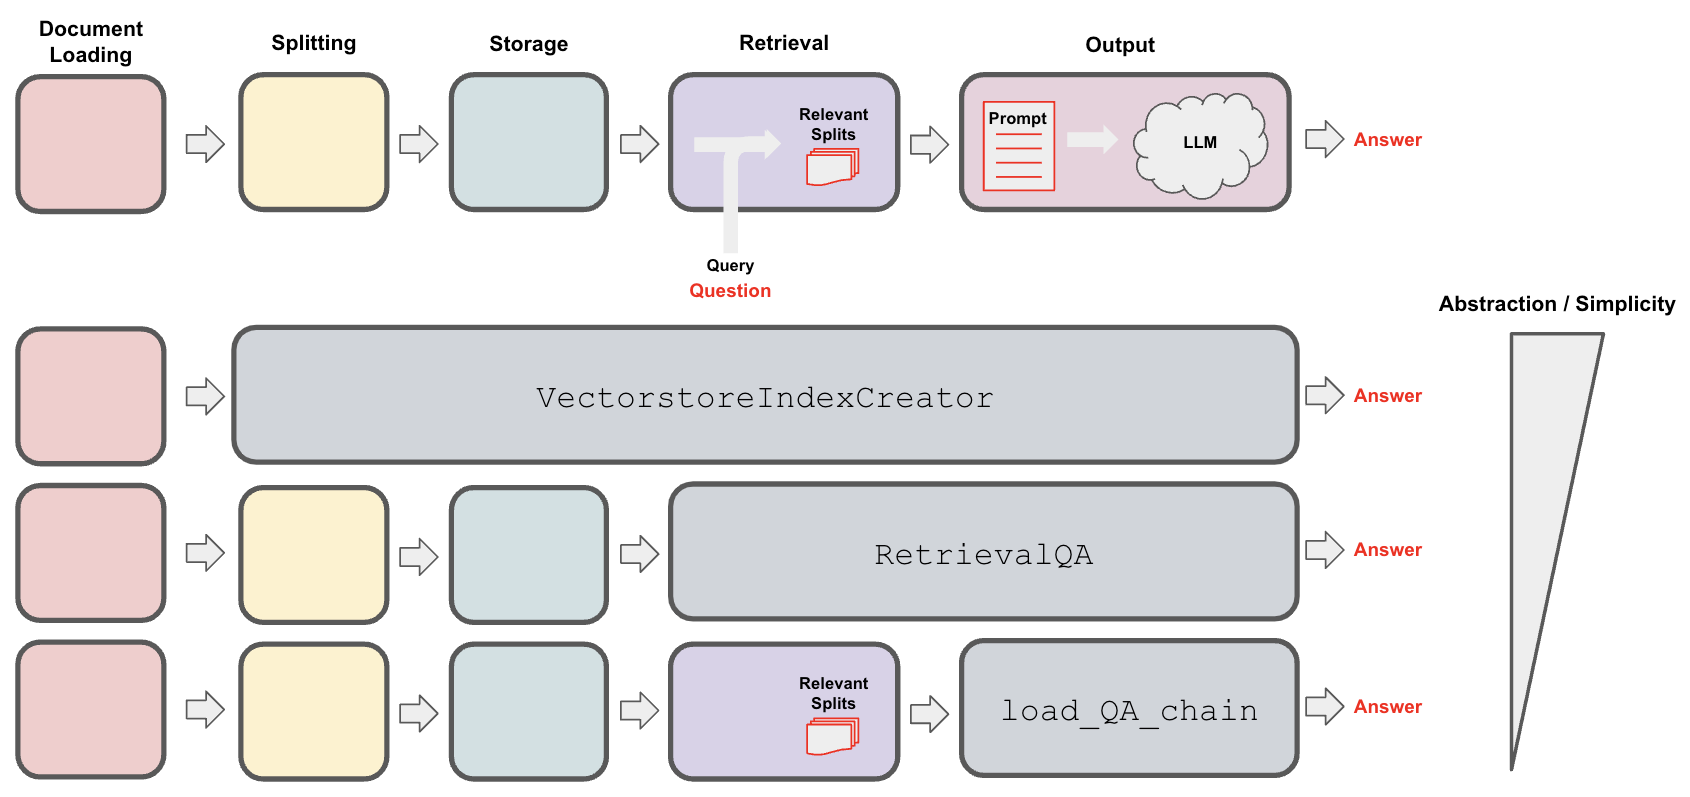

In [ ]:
from langchain.chains import RetrievalQA
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=docsearch,
    chain_type="stuff",
)
result = qa_chain({"query": query})